In [1]:
import sys
sys.path.append('./.local/lib/python3.8/site-packages')
sys.path.append('/usr/lib/python3/dist-packages')

from keras import losses, metrics, utils
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Activation, Input
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, concatenate, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, interp
import os, sys, pickle, shutil
import pandas as pd
import numpy as np
import random, datetime, time
from sklearn.model_selection import KFold
#from keras.utils.training_utils import multi_gpu_model


# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
SEED = 98
GPU = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]= f"{GPU}"  

print(datetime.datetime.now())

2023-09-22 20:53:37.837839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 20:53:38.592934: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda-3-2020.02/envs/hskim/lib/python3.8/site-packages/nvidia/cuda_nvrtc/lib:/opt/anaconda-3-2020.02/envs/hskim/lib/python3.8/site-packages/nvidia/cudnn/lib:/opt/anaconda-3-2020.02/envs/hskim/lib/python3.8/site-packages/nvidia/cublas/lib:/opt/anaconda-3-2020.02/envs/hskim/lib/python3.8/site-packages/nvidia/cudnn/lib:/opt/anaconda-3-2020.02/envs/hskim/lib/:/usr/local/cudnn-112-81133/lib64:/u

2023-09-22 20:53:39.979275


# Input loading

In [3]:
SRATE = 500
ECG_FILT = 'bandpass'
TRAIN = 'train'
ADULT = 'adult'
NORM = 'z-norm'
GENDER = 'male'


hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{TRAIN}'
input_path = f'dataset/{hyper_path}/'

with np.load(input_path+'x.npz', allow_pickle=True) as f:
    x_train = f['x_train']
    x_test = f['x_test']
        
with np.load(input_path+'y.npz', allow_pickle=True) as f:
    y_train = f['y_train']
    y_test = f['y_test']
    
with np.load(input_path+'c.npz', allow_pickle=True) as f:
    c_train = f['c_train']
    c_test = f['c_test']  
    
with np.load(input_path+'g.npz', allow_pickle=True) as f:
    g_train = f['g_train']
    g_test = f['g_test']        
    
print(f'x train shape: {x_train.shape}')
print(f'x test shape: {x_test.shape}')

x train shape: (27844, 5000, 12)
x test shape: (6965, 5000, 12)


In [4]:
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'

train_mask = (g_train == 1) if GENDER == 'male' else (g_train == 0)
test_mask = (g_test == 1) if GENDER == 'male' else (g_test == 0)

x_train = x_train[train_mask]
y_train = y_train[train_mask]
c_train = c_train[train_mask]
g_train = g_train[train_mask]

x_test = x_test[test_mask]
y_test = y_test[test_mask]
c_test = c_test[test_mask]
g_test = g_test[test_mask]

print(f'x train shape: {x_train.shape}')
print(f'x test shape: {x_test.shape}')

x train shape: (13378, 5000, 12)
x test shape: (3390, 5000, 12)


## signal + features

In [2]:
SRATE = 500
ECG_FILT = 'bandpass'
TRAIN = 'train'
ADULT = 'adult'
NORM = 'z-norm'
GENDER = 'male'

hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{TRAIN}'
input_path = f'dataset/{hyper_path}/signal+features/'

with np.load(input_path+'x.npz', allow_pickle=True) as f:
    x_train = f['x_train']
    x_test = f['x_test']
     
with np.load(input_path+'feats.npz', allow_pickle=True) as f:
    feat_train = f['feat_train']
    feat_test = f['feat_test']
        
with np.load(input_path+'y.npz', allow_pickle=True) as f:
    y_train = f['y_train']
    y_test = f['y_test']
    
with np.load(input_path+'c.npz', allow_pickle=True) as f:
    c_train = f['c_train']
    c_test = f['c_test']  
    
with np.load(input_path+'g.npz', allow_pickle=True) as f:
    g_train = f['g_train']
    g_test = f['g_test']        
    
print(f'x train shape: {x_train.shape}')
print(f'feat train shape: {feat_train.shape}')
print(f'x test shape: {x_test.shape}')
print(f'feat test shape: {feat_test.shape}')

hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'

train_mask = (g_train == 1) if GENDER == 'male' else (g_train == 0)
test_mask = (g_test == 1) if GENDER == 'male' else (g_test == 0)

x_train = x_train[train_mask]
feat_train = feat_train[train_mask]
y_train = y_train[train_mask]
c_train = c_train[train_mask]
g_train = g_train[train_mask]

x_test = x_test[test_mask]
feat_test = feat_test[test_mask]
y_test = y_test[test_mask]
c_test = c_test[test_mask]
g_test = g_test[test_mask]

print(f'x train shape: {x_train.shape}')
print(f'feat train shape: {feat_train.shape}')
print(f'x test shape: {x_test.shape}')
print(f'feat test shape: {feat_test.shape}')


SCALE_Y = (100 if ADULT == 'adult' else 20)
y_train = y_train / SCALE_Y
y_test = y_test / SCALE_Y

print(f'train: {np.mean(y_train)}, test: {np.mean(y_test)}')

x train shape: (27824, 5000, 12)
feat train shape: (27824, 55)
x test shape: (6962, 5000, 12)
feat test shape: (6962, 55)
x train shape: (13358, 5000, 12)
feat train shape: (13358, 55)
x test shape: (3387, 5000, 12)
feat test shape: (3387, 55)
train: 0.6191248297691345, test: 0.6184705495834351


### augmentation

In [9]:
import numpy as np
from tqdm import tqdm

class lead_extractor:
    """
    used to select specific leads or random choice of configurations

    Twelve leads: I, II, III, V1, V2, V3, V4, V5, V6, aVR, aVL, aVF, 
    Six leads: I, II, V1, V3, V4, V6
    Four leads: III, V1, V2, aVL # I, II, III, V2
    Three leads: I, II, V2
    Two leads: I, II

    """
    L2 = np.array([1,1,0,0,0,0,0,0,0,0,0,0])
    L3 = np.array([1,1,0,0,0,0,0,1,0,0,0,0])
    L4 = np.array([0,0,1,1,1,0,0,0,0,0,1,0]) #([1,1,1,0,0,0,0,1,0,0,0,0])
    L6 = np.array([1,1,0,1,0,1,1,0,1,0,0,0])
    L8 = np.array([1,1,0,1,0,1,1,1,1,0,1,0])
    L12 = np.array([1,1,1,1,1,1,1,1,1,1,1,1])

    @staticmethod
    def get (x,num_leads):
        if num_leads==None:
            # random choice output
            num_leads = random.choice([12,8,6,4,3,2])

        if num_leads==12:
            # Twelve leads: I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5, V6
            return x

        if num_leads==8:
            # Six leads: I, II, III, aVL, aVR, aVF
            x = x * lead_extractor.L8
            return x

        if num_leads==6:
            # Six leads: I, II, III, aVL, aVR, aVF
            x = x * lead_extractor.L6
            return x

        if num_leads==4:
            # Six leads: I, II, III, V2
            x = x * lead_extractor.L4
            return x

        if num_leads==3:
            # Three leads: I, II, V2
            x = x * lead_extractor.L3
            return x

        if num_leads==2:
            # Two leads: II, V5
            x = x * lead_extractor.L2
            return x
        raise Exception("invalid-leads-number")

def aug_generator(n_aug, x_train, feat_train, y_train, c_train, g_train):
    from tqdm import tqdm
    x_train_, feat_train_, y_train_, c_train_, g_train_ = [], [], [], [], []
    for i in tqdm(range(x_train.shape[0])):
        x_train_.append(x_train[i])
        feat_train_.append(feat_train[i])
        y_train_.append(y_train[i])
        c_train_.append(c_train[i])
        g_train_.append(g_train[i])

        x_train_.append(lead_extractor.get(x_train[i], 8))
        feat_train_.append(feat_train[i])
        y_train_.append(y_train[i])
        c_train_.append(c_train[i])
        g_train_.append(g_train[i])    

        if n_aug > 2:
            x_train_.append(lead_extractor.get(x_train[i], 6))
            feat_train_.append(feat_train[i])
            y_train_.append(y_train[i])
            c_train_.append(c_train[i])
            g_train_.append(g_train[i])  

        if n_aug > 3:
            x_train_.append(lead_extractor.get(x_train[i], 4))
            feat_train_.append(feat_train[i])
            y_train_.append(y_train[i])
            c_train_.append(c_train[i])
            g_train_.append(g_train[i]) 

    x_train_ = np.array(x_train_, np.float32)
    feat_train_ = np.array(feat_train_, np.float32)
    y_train_ = np.array(y_train_, np.float32)
    c_train_ = np.array(c_train_)
    g_train_ = np.array(g_train_, np.float32)

    print(f'x shape: {x_train_.shape}')
    print(f'feat shape: {feat_train_.shape}')
    print(f'y shape: {y_train_.shape}')
    
    return x_train_, feat_train_, y_train_, c_train_, g_train_

In [10]:
x_train, feat_train, y_train, c_train, g_train = aug_generator(2, x_train, feat_train, y_train, c_train, g_train)

100%|██████████| 13358/13358 [00:03<00:00, 3775.90it/s]


x shape: (26716, 5000, 12)
feat shape: (26716, 55)
y shape: (26716,)


# Model

## 1d-cnn + random lead generator

In [38]:
class lead_extractor:
    """
    used to select specific leads or random choice of configurations

    Twelve leads: I, II, III, V1, V2, V3, V4, V5, V6, aVR, aVL, aVF, 
    Six leads: I, II, V1, V3, V4, V6
    Four leads: III, V1, V2, aVL # I, II, III, V2
    Three leads: I, II, V2
    Two leads: I, II

    """
    L2 = np.array([1,1,0,0,0,0,0,0,0,0,0,0])
    L3 = np.array([1,1,0,0,0,0,0,1,0,0,0,0])
    L4 = np.array([0,0,1,1,1,0,0,0,0,0,1,0]) #([1,1,1,0,0,0,0,1,0,0,0,0])
    L6 = np.array([1,1,0,1,0,1,1,0,1,0,0,0])
    L8 = np.array([1,1,0,1,0,1,1,1,1,0,1,0])
    L12 = np.array([1,1,1,1,1,1,1,1,1,1,1,1])

    @staticmethod
    def get (x,num_leads):
        if num_leads==None:
            # random choice output
            num_leads = random.choice([12,8,6,4,3,2])

        if num_leads==12:
            # Twelve leads: I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5, V6
            return x

        if num_leads==8:
            # Six leads: I, II, III, aVL, aVR, aVF
            x = x * lead_extractor.L8
            return x

        if num_leads==6:
            # Six leads: I, II, III, aVL, aVR, aVF
            x = x * lead_extractor.L6
            return x

        if num_leads==4:
            # Six leads: I, II, III, V2
            x = x * lead_extractor.L4
            return x

        if num_leads==3:
            # Three leads: I, II, V2
            x = x * lead_extractor.L3
            return x

        if num_leads==2:
            # Two leads: II, V5
            x = x * lead_extractor.L2
            return x
        raise Exception("invalid-leads-number")

In [41]:
class CustomDataGenerator(utils.Sequence):
    def __init__(self, x_data, y_data, batch_size):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.x_data))

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size

        batch_x = self.x_data[self.indexes[start:end]]
        batch_y = self.y_data[self.indexes[start:end]]
        
        batch_x = lead_extractor.get(batch_x, num_leads=None)

        return batch_x, batch_y

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

In [30]:
batch_size = 64
n_conv = 4
nfilt = [64,64,16,128]
kernels = [3,5,9,7]
strides=[1,2,2,1]
dropout_cnn = 0.3
dense_node = 64
dropout_fc = 0.3
pool_size = 2
learning_rate= 0.001


# 이번 옵션에 대한 결과 디렉토리
odir_f = f'batch{batch_size},'
for i in range(n_conv):
    odir_f += f'layer{i+1}:c{nfilt[i]}filt{kernels[i]}str{strides[i]},'
odir_f += f'1conv,dropout{dropout_cnn},dnodes{dense_node},dropout{dropout_fc},lr{learning_rate}'

rootdir = 'result'
odir = rootdir + '/' + odir_f
if not os.path.exists(odir):
    os.mkdir(odir)

Epoch 1/100


/tmp/ipykernel_3081698/3675947081.py:70: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator=data_generator, validation_data =(X_val, Y_val), epochs=100,


126/126 [==============================] - ETA: 0s - loss: 1274.1620 - mean_absolute_error: 28.0096
Epoch 1: val_loss improved from inf to 537.29755, saving model to result/batch64,layer1:c64filt3str1,layer2:c64filt5str2,layer3:c16filt9str2,layer4:c128filt7str1,1conv,dropout0.3,dnodes64,dropout0.3/weights_0.hdf5
126/126 [==============================] - 6s 28ms/step - loss: 1274.1620 - mean_absolute_error: 28.0096 - val_loss: 537.2975 - val_mean_absolute_error: 20.5664
Epoch 2/100
124/126 [============================>.] - ETA: 0s - loss: 274.9873 - mean_absolute_error: 13.2647
Epoch 2: val_loss improved from 537.29755 to 232.70361, saving model to result/batch64,layer1:c64filt3str1,layer2:c64filt5str2,layer3:c16filt9str2,layer4:c128filt7str1,1conv,dropout0.3,dnodes64,dropout0.3/weights_0.hdf5
126/126 [==============================] - 3s 24ms/step - loss: 275.3063 - mean_absolute_error: 13.2651 - val_loss: 232.7036 - val_mean_absolute_error: 11.6197
Epoch 3/100
124/126 [=============

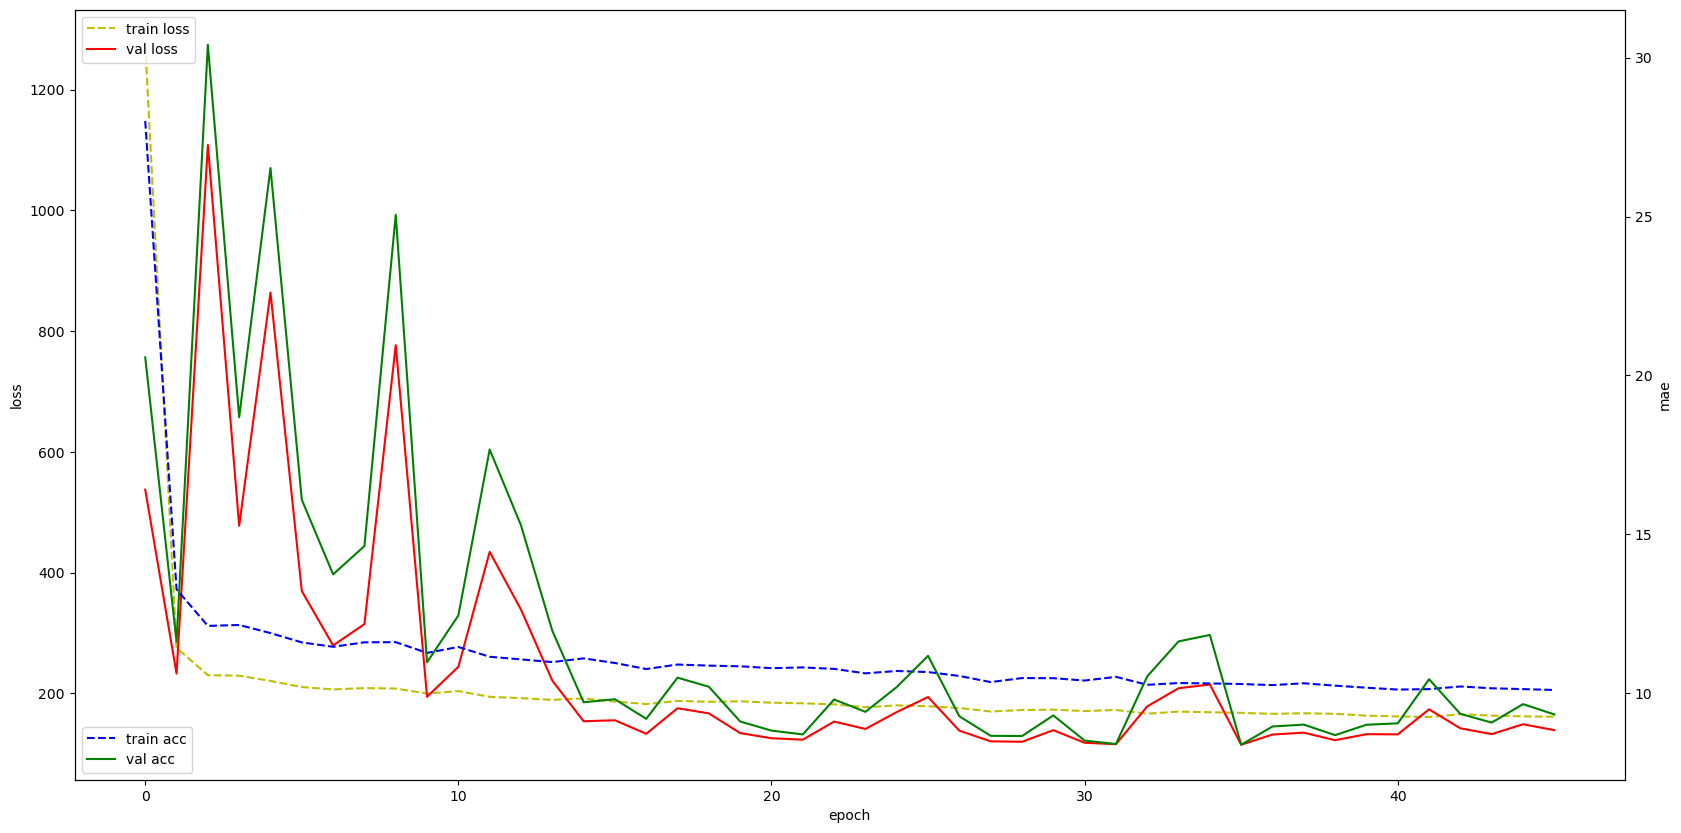

Epoch 1/100
125/126 [============================>.] - ETA: 0s - loss: 183.4886 - mean_absolute_error: 10.8107
Epoch 1: val_loss improved from inf to 114.59554, saving model to result/batch64,layer1:c64filt3str1,layer2:c64filt5str2,layer3:c16filt9str2,layer4:c128filt7str1,1conv,dropout0.3,dnodes64,dropout0.3/weights_1.hdf5
126/126 [==============================] - 7s 29ms/step - loss: 183.6082 - mean_absolute_error: 10.8158 - val_loss: 114.5955 - val_mean_absolute_error: 8.1645
Epoch 2/100
124/126 [============================>.] - ETA: 0s - loss: 176.4763 - mean_absolute_error: 10.5286
Epoch 2: val_loss did not improve from 114.59554
126/126 [==============================] - 3s 25ms/step - loss: 176.0929 - mean_absolute_error: 10.5221 - val_loss: 287.4429 - val_mean_absolute_error: 14.0826
Epoch 3/100
124/126 [============================>.] - ETA: 0s - loss: 175.1660 - mean_absolute_error: 10.5002
Epoch 3: val_loss did not improve from 114.59554
126/126 [===========================

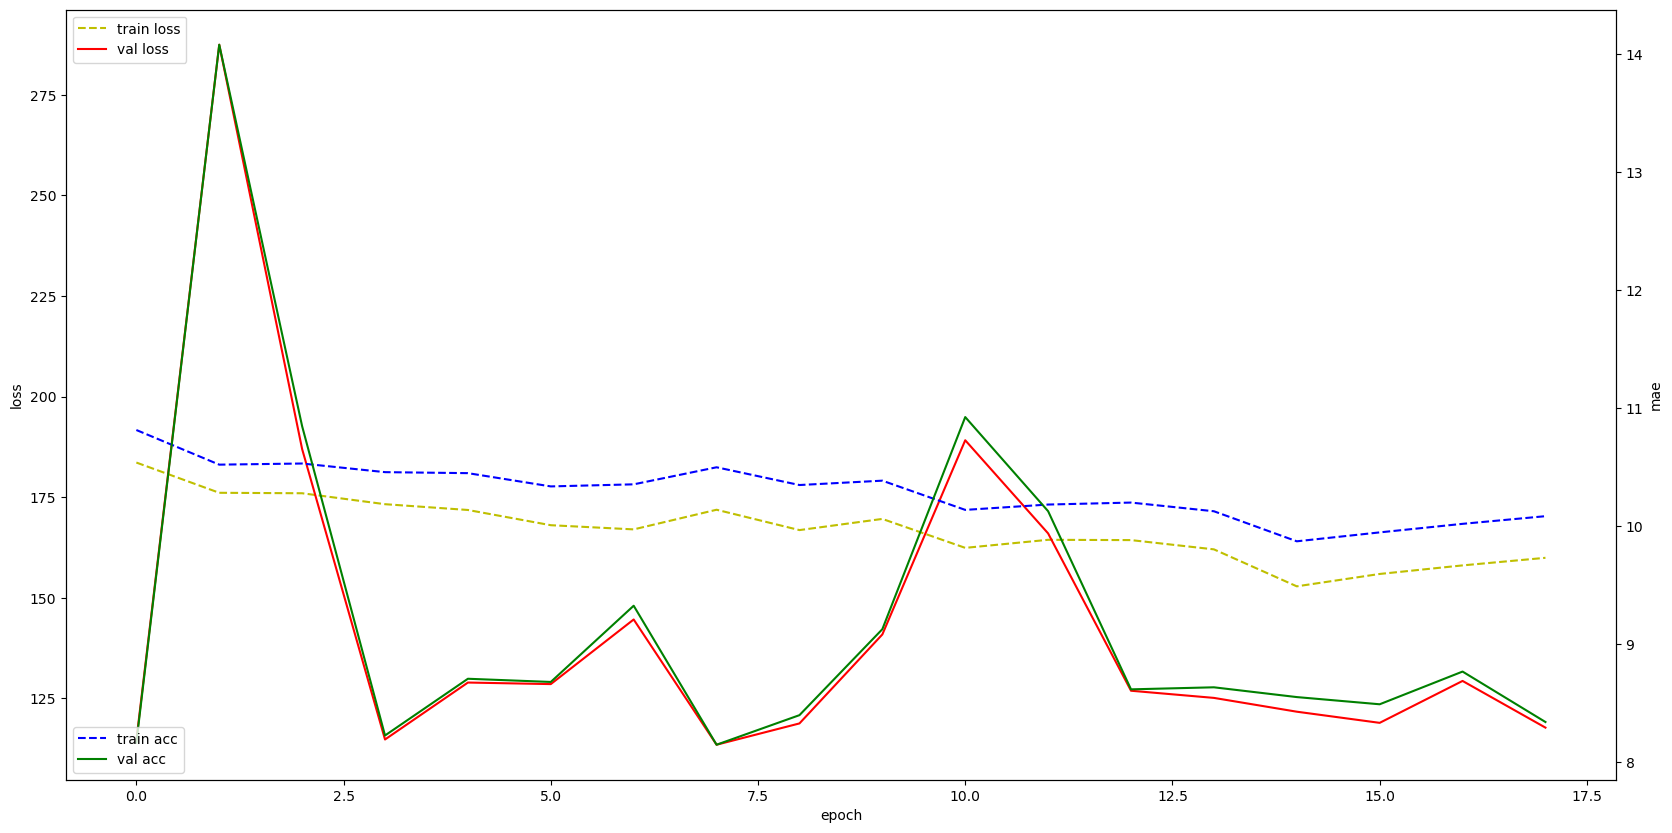

Epoch 1/100
124/126 [============================>.] - ETA: 0s - loss: 173.1050 - mean_absolute_error: 10.4808
Epoch 1: val_loss improved from inf to 126.55524, saving model to result/batch64,layer1:c64filt3str1,layer2:c64filt5str2,layer3:c16filt9str2,layer4:c128filt7str1,1conv,dropout0.3,dnodes64,dropout0.3/weights_2.hdf5
126/126 [==============================] - 7s 29ms/step - loss: 173.2674 - mean_absolute_error: 10.4855 - val_loss: 126.5552 - val_mean_absolute_error: 8.6870
Epoch 2/100
126/126 [==============================] - ETA: 0s - loss: 166.6353 - mean_absolute_error: 10.3034
Epoch 2: val_loss did not improve from 126.55524
126/126 [==============================] - 3s 24ms/step - loss: 166.6353 - mean_absolute_error: 10.3034 - val_loss: 142.6280 - val_mean_absolute_error: 9.3723
Epoch 3/100
126/126 [==============================] - ETA: 0s - loss: 166.3009 - mean_absolute_error: 10.2731
Epoch 3: val_loss did not improve from 126.55524
126/126 [============================

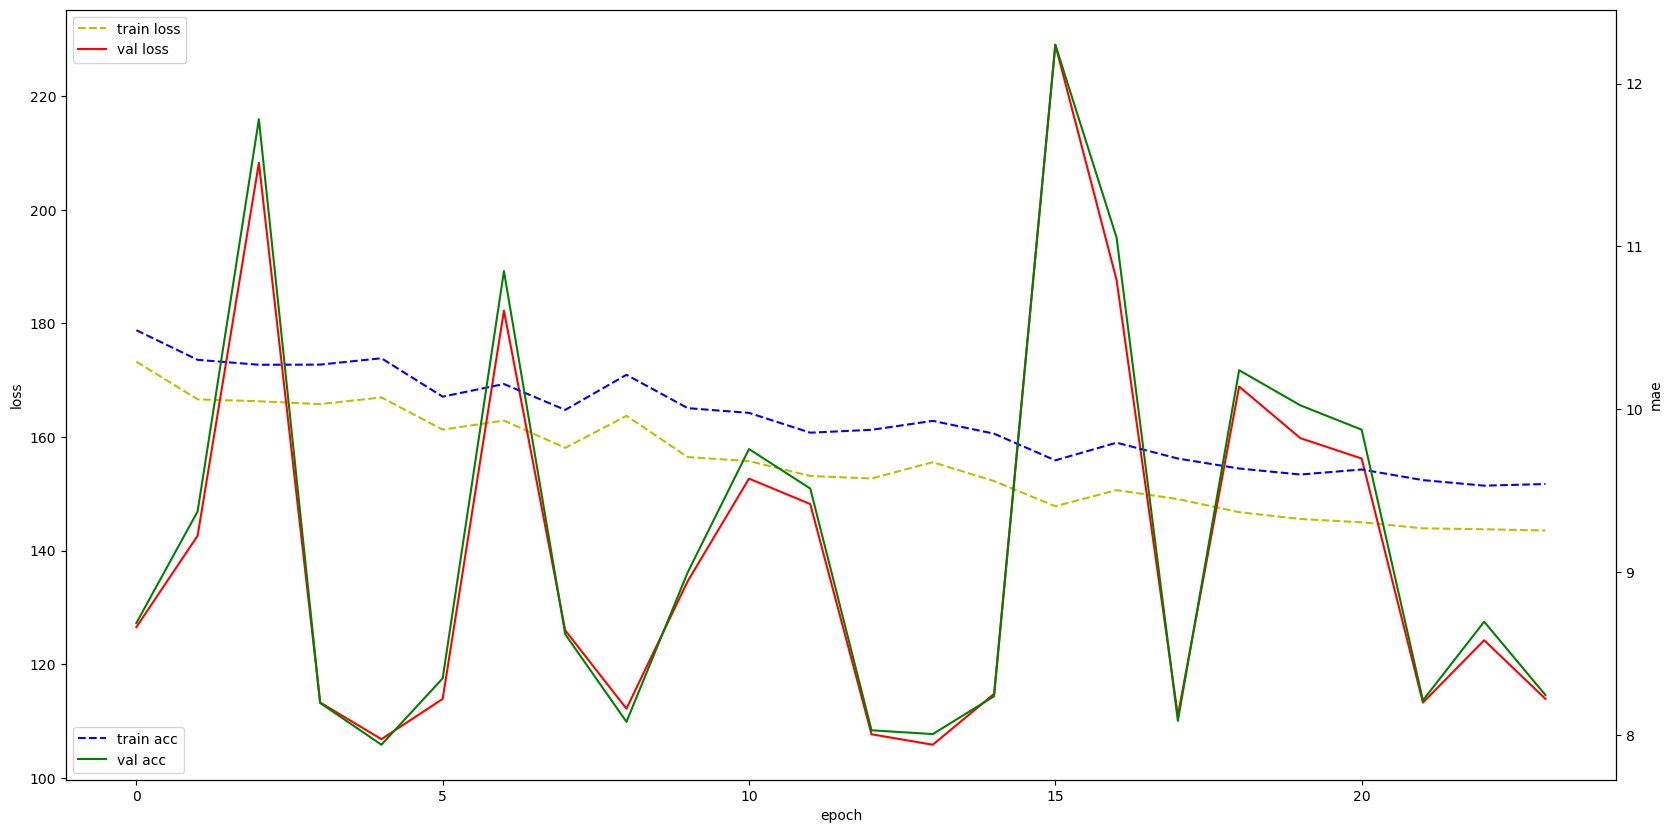

Epoch 1/100
124/126 [============================>.] - ETA: 0s - loss: 159.2608 - mean_absolute_error: 10.0256
Epoch 1: val_loss improved from inf to 183.14732, saving model to result/batch64,layer1:c64filt3str1,layer2:c64filt5str2,layer3:c16filt9str2,layer4:c128filt7str1,1conv,dropout0.3,dnodes64,dropout0.3/weights_3.hdf5
126/126 [==============================] - 7s 29ms/step - loss: 159.1149 - mean_absolute_error: 10.0236 - val_loss: 183.1473 - val_mean_absolute_error: 10.8000
Epoch 2/100
124/126 [============================>.] - ETA: 0s - loss: 159.0980 - mean_absolute_error: 9.9978 
Epoch 2: val_loss improved from 183.14732 to 119.42866, saving model to result/batch64,layer1:c64filt3str1,layer2:c64filt5str2,layer3:c16filt9str2,layer4:c128filt7str1,1conv,dropout0.3,dnodes64,dropout0.3/weights_3.hdf5
126/126 [==============================] - 3s 25ms/step - loss: 159.0776 - mean_absolute_error: 9.9935 - val_loss: 119.4287 - val_mean_absolute_error: 8.5853
Epoch 3/100
124/126 [=====

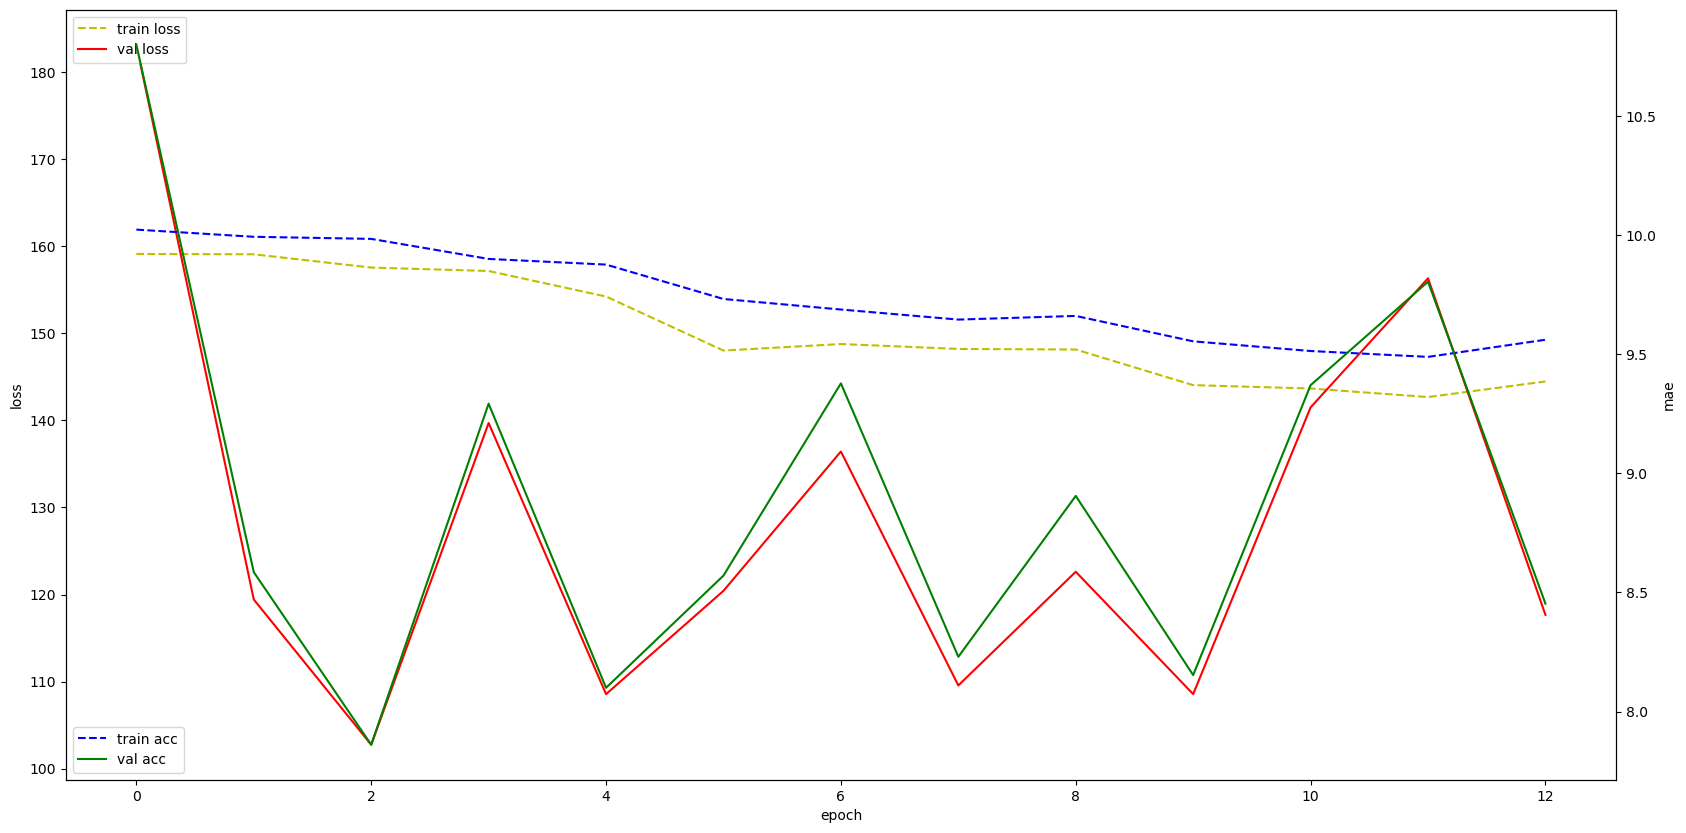

In [51]:
nfold = 4

inp = Input(shape=(x_train.shape[1],x_train.shape[2]))
out = inp


# VGC block
for i in range(n_conv):
    out = Conv1D(filters=nfilt[i], kernel_size=kernels[i], strides=strides[i], padding='same', activation='relu')(out)
    out = BatchNormalization()(out)
    out = MaxPooling1D(pool_size)(out)


# globalpooling vs flattening vs 1x1 convolution
#elif globalpool_opt == 'ave':
#    out = GlobalAveragePooling1D()(out)
out = Conv1D(filters=1, kernel_size=1)(out)
out = Flatten() (out)




if dense_node != 0:
    out = Dropout(dropout_cnn)(out)
    out = Dense(dense_node, activation='relu')(out)
out = Dropout(dropout_fc)(out)
out = Dense(1, activation='linear')(out)


model = Model(inputs=[inp], outputs=[out])
model.save_weights(f'{odir}/initial_weights.hdf5')


# 4-fold cv
kfold = KFold(nfold)
tprs, aucs, prs = [], [], []
test_rmse, test_mae = [], []
f1_scores, thvals = [], []
mean_fpr = np.linspace(0,1,100)
mean_recall = np.linspace(0,1,100)

switch = 0
caseids_train = np.unique(c_train)
for fold, (c_cv_trains_mask, c_cv_test_mask) in enumerate(kfold.split(caseids_train)):
    c_cv_trains = caseids_train[c_cv_trains_mask]
    random.shuffle(c_cv_trains)

    ncv = int(len(c_cv_trains)*0.8)
    c_cv_train = c_cv_trains[:ncv]
    c_cv_val = c_cv_trains[ncv:]

    cv_train_mask = np.isin(c_train, c_cv_train)
    cv_val_mask = np.isin(c_train, c_cv_val)
    cv_test_mask = np.isin(c_train, caseids_train[c_cv_test_mask])

    X_train = x_train[cv_train_mask]
    X_val = x_train[cv_val_mask]
    X_test = x_train[cv_test_mask] 

    Y_train = y_train[cv_train_mask]
    Y_val = y_train[cv_val_mask]
    Y_test = y_train[cv_test_mask]

    data_generator = CustomDataGenerator(X_train, Y_train, batch_size)
    # model 학습

    weightcache = f"{odir}/weights_{fold}.hdf5"
    #model = multi_gpu_model(model, gpus=4)
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate), metrics=['mean_absolute_error'])
    hist = model.fit_generator(generator=data_generator, validation_data =(X_val, Y_val), epochs=100, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])
    #hist = model.fit(data_generator, validation_data=(X_val, Y_val), epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
    #                        callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
    #                                    EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])

    model.load_weights(weightcache)
    y_pred = model.predict(X_test).flatten()

    # MAE 계산
    model_err = metrics.MeanAbsoluteError()
    model_err.update_state(Y_test, y_pred)
    mae_val = model_err.result().numpy()
    test_mae.append(mae_val)

    # RMSE 계산
    model_err = metrics.RootMeanSquaredError() 
    model_err.update_state(Y_test, y_pred)
    rmse_val = model_err.result().numpy()
    test_rmse.append(rmse_val)
    
    plot_hist(hist)
    

## cnn-transformer

In [ ]:
random.seed(98)

from keras.models import Model
from keras.layers import Layer, LayerNormalization, Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, concatenate, multiply, dot, MultiHeadAttention
from keras.callbacks import EarlyStopping, ModelCheckpoint


SRATE = 500  # in hz
SEGLEN = 10 * SRATE  # samples
BATCH_SIZE = 256
MAX_CASES = 500


hyperparameters = {
    "nfilt" : [16, 32, 64],
    'nhead' : [2, 3, 4],
    'kdim': [16, 32, 64],
    "fnode" : [32, 64, 128],
    "clayer" : [2, 3],
    "tlayer" : [3, 4],
    "droprate" : [0.1, 0.2],
    "filtsize" : [5, 7, 9, 11],
    'poolsize' : [4, 5]
}
keys, values = zip(*hyperparameters.items())
permutations_dicts = it.product(*values)
permutations_dicts = list(permutations_dicts)
random.shuffle(permutations_dicts)
for nfilt, nhead, kdim, fnode, clayer, tlayer, droprate, filtsize, poolsize in permutations_dicts:
    test_start = time.time()

    tf.keras.backend.clear_session()
    
    rootdir = f'randomSearch/{hyper_path}/CNN+transformer_{MAX_CASES}cases_{SEGLEN // SRATE}sec'
    odir_f = 'batch{} cnn{} filt{} size{} pool{} do{}'.format(BATCH_SIZE, clayer, nfilt, filtsize, poolsize, droprate)
    odir_f += '_tra{} head{} kdim{} fnn{}'.format(tlayer, nhead, kdim, fnode)
    
    if not os.path.exists(rootdir):
        os.mkdir(rootdir)
    
    odir = rootdir+'/'+odir_f
    print("============================")
    print(odir)
    print("============================")

    # cnn-transformer
    # https://keras.io/examples/nlp/text_classification_with_transformer/
    out = inp = Input(shape=(x_train.shape[1], x_train.shape[2]))
    
    # out = Conv1D(filters=kdim, kernel_size=filtsize, padding='same')(out)

    # conv 여러층    
    for i in range(clayer):
        out = Conv1D(filters=nfilt, kernel_size=filtsize, padding='same', activation='relu')(out)
        out = MaxPooling1D(poolsize, padding='same')(out)
    out = Dense(kdim)(out)  # 마지막 차원이 nfilt 인데 kdim 으로 바꿔야 transformer block을 쌓을 수 있다.
    for i in range(tlayer):  # transformer
        attn_output = MultiHeadAttention(num_heads=nhead, key_dim=kdim, attention_axes=[1,])(out, out)
        attn_output = Dropout(droprate)(attn_output)
        out1 = LayerNormalization(epsilon=1e-6)(out + attn_output)  # sum and norm
        ffn_output = tf.keras.Sequential([Dense(fnode, activation="relu"), Dense(kdim)])(out1)
        out2 = Dropout(droprate)(ffn_output)
        out = LayerNormalization(epsilon=1e-6)(out1 + out2)  # sum and norm
    out = GlobalMaxPooling1D()(out)

    if droprate:
        out = Dropout(droprate)(out)
    out = Dense(fnode)(out)
    if droprate:
        out = Dropout(droprate)(out)
    out = Dense(1)(out)

    if not os.path.exists(odir):
        os.mkdir(odir)

    cache_path = odir + "/weights.hdf5"
    model = Model(inputs=[inp], outputs=[out])
    model.summary()
    model.compile(loss='mae', optimizer='adam')
    
    try:
        hist = model.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=BATCH_SIZE,
                        callbacks=[ModelCheckpoint(monitor='val_loss', filepath=cache_path, verbose=1, save_best_only=True),
                                   EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'),
                                   #LearningRateScheduler(lr_scheduler, verbose=0),
                                   ])
        model.load_weights(cache_path)  # best 모델을 다시 읽음
        js = model.to_json()
        with open(odir + '/model.json', 'w') as f:  # best 모델을 저장
            f.write(js)


        y_pred = model.predict(x_test).flatten()

        # MAE 계산
        model_err = metrics.MeanAbsoluteError()
        model_err.update_state(y_test, y_pred)
        mae_val = model_err.result().numpy()

        # RMSE 계산
        model_err = metrics.RootMeanSquaredError() 
        model_err.update_state(y_test, y_pred)
        rmse_val = model_err.result().numpy()


        print(f'val mae {mae_val:.2f}, val rmse {rmse_val:.2f}###')
        
        os.rename(odir, rootdir+f'/mae{mae_val:.2f}_rmse{rmse_val:.2f}_{odir_f}')
        tf.keras.backend.clear_session()
        

    except Exception as e:
        print(e)
        tf.keras.backend.clear_session()
        shutil.rmtree(odir)
        continue

randomSearch/SRATE500_ECG-bandpass_z-norm_adult_male_train/CNN+transformer_500cases_10sec/batch256 cnn2 filt64 size7 pool4 do0.2_tra3 head2 kdim64 fnn128
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5000, 12)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 5000, 64)     5440        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 1250, 64)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 

2023-09-20 22:40:49.310044: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-20 22:40:49.310101: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


42/42 [==============================] - ETA: 0s - loss: 16.1618
Epoch 2: val_loss improved from 44.16267 to 33.94817, saving model to randomSearch/SRATE500_ECG-bandpass_z-norm_adult_male_train/CNN+transformer_500cases_10sec/batch256 cnn3 filt64 size5 pool5 do0.1_tra4 head3 kdim16 fnn128/weights.hdf5
42/42 [==============================] - 3s 69ms/step - loss: 16.1618 - val_loss: 33.9482
Epoch 3/50
41/42 [============================>.] - ETA: 0s - loss: 12.8904
Epoch 3: val_loss improved from 33.94817 to 29.09124, saving model to randomSearch/SRATE500_ECG-bandpass_z-norm_adult_male_train/CNN+transformer_500cases_10sec/batch256 cnn3 filt64 size5 pool5 do0.1_tra4 head3 kdim16 fnn128/weights.hdf5
42/42 [==============================] - 3s 63ms/step - loss: 12.8832 - val_loss: 29.0912
Epoch 4/50
41/42 [============================>.] - ETA: 0s - loss: 11.1958
Epoch 4: val_loss improved from 29.09124 to 27.93653, saving model to randomSearch/SRATE500_ECG-bandpass_z-norm_adult_male_train/

2023-09-20 22:57:36.888880: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-20 22:57:36.888937: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


41/42 [============================>.] - ETA: 0s - loss: 14.2345
Epoch 2: val_loss improved from 29.38801 to 22.49485, saving model to randomSearch/SRATE500_ECG-bandpass_z-norm_adult_male_train/CNN+transformer_500cases_10sec/batch256 cnn3 filt64 size9 pool5 do0.1_tra3 head4 kdim32 fnn64/weights.hdf5
42/42 [==============================] - 3s 71ms/step - loss: 14.2041 - val_loss: 22.4948
Epoch 3/50
41/42 [============================>.] - ETA: 0s - loss: 11.8203
Epoch 3: val_loss improved from 22.49485 to 21.10016, saving model to randomSearch/SRATE500_ECG-bandpass_z-norm_adult_male_train/CNN+transformer_500cases_10sec/batch256 cnn3 filt64 size9 pool5 do0.1_tra3 head4 kdim32 fnn64/weights.hdf5
42/42 [==============================] - 3s 60ms/step - loss: 11.8181 - val_loss: 21.1002
Epoch 4/50
41/42 [============================>.] - ETA: 0s - loss: 11.1839
Epoch 4: val_loss improved from 21.10016 to 17.11992, saving model to randomSearch/SRATE500_ECG-bandpass_z-norm_adult_male_train/CN

2023-09-20 23:07:42.230154: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-20 23:07:42.230207: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_loss improved from inf to 25.41816, saving model to randomSearch/SRATE500_ECG-bandpass_z-norm_adult_male_train/CNN+transformer_500cases_10sec/batch256 cnn3 filt32 size9 pool5 do0.1_tra3 head4 kdim32 fnn32/weights.hdf5
42/42 [==============================] - 12s 84ms/step - loss: 41.0663 - val_loss: 25.4182
Epoch 2/50
41/42 [============================>.] - ETA: 0s - loss: 15.3972
Epoch 2: val_loss improved from 25.41816 to 14.65451, saving model to randomSearch/SRATE500_ECG-bandpass_z-norm_adult_male_train/CNN+transformer_500cases_10sec/batch256 cnn3 filt32 size9 pool5 do0.1_tra3 head4 kdim32 fnn32/weights.hdf5
42/42 [==============================] - 2s 50ms/step - loss: 15.3632 - val_loss: 14.6545
Epoch 3/50
41/42 [============================>.] - ETA: 0s - loss: 12.5855
Epoch 3: val_loss improved from 14.65451 to 12.43286, saving model to randomSearch/SRATE500_ECG-bandpass_z-norm_adult_male_train/CNN+transformer_500cases_10sec/batch256 cnn3 filt32 size9 pool5 do0.1_

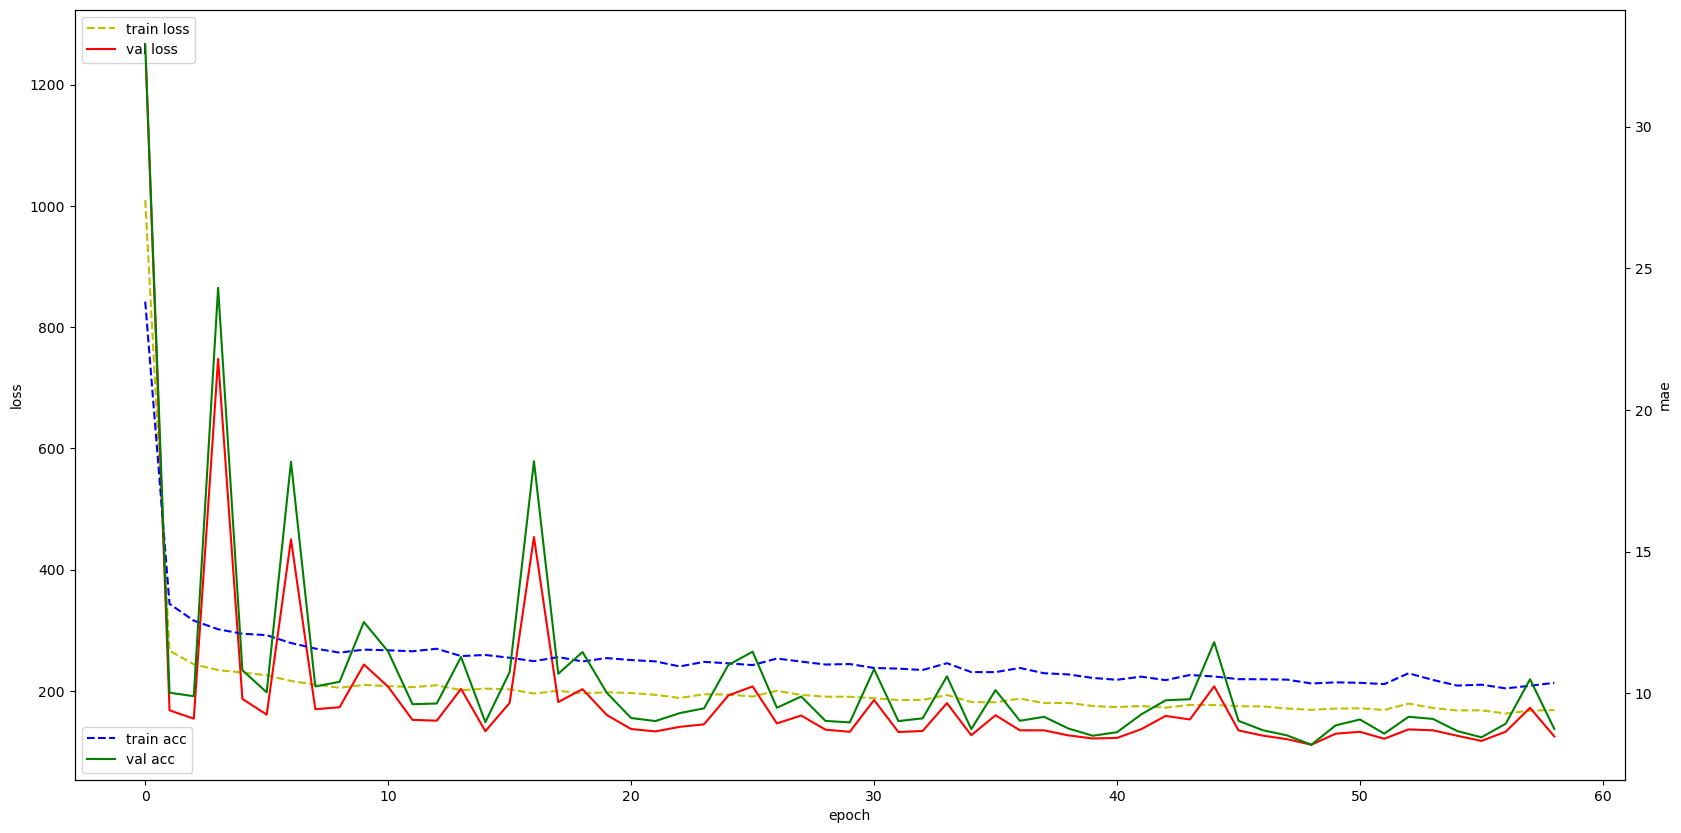

In [50]:
plot_hist(hist)

In [47]:
def plot_hist(hist):

    fig, loss_ax = plt.subplots(figsize=(20,10))

    #x-axis는 공유하지만 y-axis는 공유x
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', linestyle='dashed', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

    #acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
    #acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')
    acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train acc')
    acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    #acc_ax.set_ylim(0.2,1.0)
    acc_ax.set_ylabel('mae')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

# Retrain

## Male model -> female

In [2]:
from keras.models import model_from_json


def best_model(models_dir, adult, gender):
    #hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{adult}_{gender}_{TRAIN}'
    #models_dir = f"randomSearch/{hyper_path}/CNN_4layers_{nfold}fold_test{ntest}"
    model_list = np.array(os.listdir(models_dir))
    
    mask = [(True if ('mae' in path) else False) for path in model_list]
    model_list = model_list[mask]
    
    perf_list = [float(path.split('+',1)[0][3:]) for path in model_list]
    best_model_path = model_list[np.argmin(perf_list)]
    
    print(f'{adult}-{gender}-best model: {best_model_path}')
    
    load_path = f'{models_dir}/{best_model_path}'
    with open(load_path+"/model.json", 'r') as f_json:
        loaded_model_json = f_json.read()
        
    loaded_model = model_from_json(loaded_model_json)
    load_weight_path = load_path+'/weights_1.hdf5'
    loaded_model.load_weights(load_weight_path)
    return loaded_model

In [16]:
from keras import metrics
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.layers import Concatenate
from sklearn.metrics import mean_absolute_error, mean_squared_error

seed_everything(SEED)

def step_decay(epoch):
    start = 1e-3
    drop = 0.1
    epochs_drop = 10
    lr = start * (drop ** np.floor((epoch)/epochs_drop))
    return lr

# loading path
SRATE = 500
ECG_FILT = 'bandpass'
TRAIN = 'train'
ADULT = 'child'
GENDER = 'male'
NORM = 'z-norm'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
rootdir_load = f'randomSearch/{hyper_path}/CNN_4layers+feats_kernel(7~19)_age%20(sigmoid)_mae(decay)_4fold_test500'

# saving path
GENDER = 'male'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
rootdir = f'randomSearch/{hyper_path}/best_retrain'
if not os.path.exists(rootdir):
    os.mkdir(rootdir)

odir_f = 'batch32,layer1:c16filt17str4,layer2:c64filt7str2,layer3:c16filt13str2,1conv,dropout0.4,dnodes64,dropout0.3'
odir = rootdir + '/' + odir_f
if not os.path.exists(odir):
    os.mkdir(odir)
dropout_cnn, dropout_fc = 0.4, 0.3
dense_node = 64
batch_size = 32
    

with tf.device(f'/gpu:{GPU}'):
    # load previous best model
    model = best_model(rootdir_load, ADULT, GENDER)

    for layer in model.layers[:-4]:
        layer.trainable = True

    # retrain model
    out = model.output
    out = Dropout(dropout_cnn, name='dropout-1')(out)
    out = Dense(dense_node, activation='relu', name='dense-1')(out)
    out = Dropout(dropout_fc, name='dropout-2')(out)
    out = Dense(1, activation='sigmoid', name='dense-2')(out)

    model_retrain = Model(inputs=model.input, outputs=[out])
    lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
    model_retrain.compile(loss='mean_squared_error', optimizer=Adam(lr=lr_scheduler, weight_decay=1e-4), metrics=['mean_absolute_error'])
    model_retrain.save_weights(f'{odir}/initial_weights.hdf5')



# 4-fold cv
kfold = KFold(nfold)
tprs, aucs, prs = [], [], []
test_rmse, test_mae = [], []
f1_scores, thvals = [], []
mean_fpr = np.linspace(0,1,100)
mean_recall = np.linspace(0,1,100)

switch = 0
caseids_train = np.unique(c_train)
for fold, (c_cv_trains_mask, c_cv_test_mask) in enumerate(kfold.split(caseids_train)):
    c_cv_trains = caseids_train[c_cv_trains_mask]

    cv_train_mask = np.isin(c_train, c_cv_trains)
    cv_val_mask = ~cv_train_mask

    X_train = x_train[cv_train_mask]
    X_val = x_train[cv_val_mask]

    Y_train = y_train[cv_train_mask]
    Y_val = y_train[cv_val_mask]

    Feat_train = feat_train[cv_train_mask]
    Feat_val = feat_train[cv_val_mask]


    # model 학습
    with tf.device("/CPU:0"):
        train_dataset = tf.data.Dataset.from_tensor_slices(({"input_1": X_train, "input_2": Feat_train}, Y_train)).shuffle(x_train.shape[0]).batch(batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices(({"input_1": X_val, "input_2": Feat_val}, Y_val)).batch(batch_size)
        test_dataset = tf.data.Dataset.from_tensor_slices(({"input_1": x_test, "input_2": feat_test}, y_test)).batch(batch_size)

    weightcache = f"{odir}/weights_{fold}.hdf5"
    #model = multi_gpu_model(model, gpus=4)
    #model.compile(loss='mean_squared_error', optimizer=Adam(lr=lr_scheduler, weight_decay=1e-4), metrics=['mean_absolute_error'])
    hist = model_retrain.fit(train_dataset, validation_data=val_dataset, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])

    model_retrain.load_weights(weightcache)
    y_pred = model_retrain.predict(test_dataset).flatten()

    # MAE 계산
    mae_val = mean_absolute_error(y_test, y_pred)
    test_mae.append(mae_val)


    print(f' ###{fold} fold : val mae {mae_val:.2f}###')
    tf.keras.backend.clear_session()
    model_retrain.load_weights(f'{odir}/initial_weights.hdf5')
    
    
    
    
mean_mae = np.mean(test_mae)
std_mae = np.std(test_mae)

max_idx = test_mae.index(min(test_mae))


print(f'mae{mean_mae*SCALE_Y:.2f}+-{std_mae*SCALE_Y:.2f}')
open(odir+"/model.json", "wt").write(model.to_json())

os.rename(odir, rootdir+f'/mae{mean_mae*SCALE_Y:.2f}+-{std_mae*SCALE_Y:.2f}_max{max_idx}__{odir_f}')
tf.keras.backend.clear_session()

adult-male-best model: mae7.60+-0.06_max0__batch32,layer1:c16filt17str4,layer2:c64filt7str2,layer3:c16filt13str2,1conv,dropout0.4,dnodes64,dropout0.3
Epoch 1/100
313/314 [============================>.] - ETA: 0s - loss: 0.0229 - mean_absolute_error: 0.1205
Epoch 1: val_loss improved from inf to 0.01905, saving model to randomSearch/SRATE500_ECG-bandpass_z-norm_adult_male_train/best_retrain/batch32,layer1:c16filt17str4,layer2:c64filt7str2,layer3:c16filt13str2,1conv,dropout0.4,dnodes64,dropout0.3/weights_0.hdf5
314/314 [==============================] - 10s 19ms/step - loss: 0.0229 - mean_absolute_error: 0.1206 - val_loss: 0.0190 - val_mean_absolute_error: 0.1069
Epoch 2/100
313/314 [============================>.] - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.1162
Epoch 2: val_loss improved from 0.01905 to 0.01893, saving model to randomSearch/SRATE500_ECG-bandpass_z-norm_adult_male_train/best_retrain/batch32,layer1:c16filt17str4,layer2:c64filt7str2,layer3:c16filt13str2,1conv,dropo

## Best model retraining

In [3]:
from keras.models import model_from_json


def best_model(models_dir, adult, gender):
    #hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{adult}_{gender}_{TRAIN}'
    #models_dir = f"randomSearch/{hyper_path}/CNN_4layers_{nfold}fold_test{ntest}"
    model_list = np.array(os.listdir(models_dir))
    
    mask = [(True if ('mae' in path) else False) for path in model_list]
    model_list = model_list[mask]
    
    perf_list = [float(path.split('+',1)[0][3:]) for path in model_list]
    best_model_path = model_list[np.argmin(perf_list)]
    
    print(f'{adult}-{gender}-best model: {best_model_path}')
    
    load_path = f'{models_dir}/{best_model_path}'
    with open(load_path+"/model.json", 'r') as f_json:
        loaded_model_json = f_json.read()
        
    loaded_model = model_from_json(loaded_model_json)
    
    #load_weight_path = load_path+'/weights_1.hdf5'
    #loaded_model.load_weights(load_weight_path)
    return loaded_model, best_model_path



SRATE = 500
ECG_FILT = 'bandpass'
TRAIN = 'train'
ADULT = 'adult'
NORM = 'z-norm'
GENDER = 'male'

hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
input_path = f'dataset/{hyper_path}/'

nfold = 4 
ntest = 500
model_folder = 'CNN+transformer_age%100(sigmoid)_loss(mae,nodecay)_4fold'
rootdir_load = f"randomSearch/{hyper_path}/{model_folder}"

In [34]:
model.summary()
#mae7.60+-_batch32,layer1:c16filt?str4,layer2:c64filt?str2,layer3:c16,filt?,str2;1conv,dropout?,dnodes64,dropout?

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5000, 12)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1250, 16)     3280        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1250, 16)    64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 1250, 16)     0           ['batch_normalization[0][0]']

In [4]:
from keras import metrics
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.layers import Concatenate
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models.experimental import SharpnessAwareMinimization

seed_everything(SEED)

START = 1e-3
DROP = 0.3
EPOCHS_DROP = 5
DECAY = 1e-4

def step_decay(epoch):
    start = START
    drop = DROP
    epochs_drop = EPOCHS_DROP
    lr = start * (drop ** np.floor((epoch)/epochs_drop))
    return lr


hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
rootdir = f'randomSearch/best_model/{hyper_path}'

odir_l = f'lr{START}_drop{DROP}_epochs_drop{EPOCHS_DROP}_decay{DECAY}_mae'
if not os.path.exists(rootdir):
    os.mkdir(rootdir)
odir = rootdir + '/' + odir_l
if not os.path.exists(odir):
    os.mkdir(odir)
    
model, odir_f = best_model(rootdir_load, ADULT, GENDER)

# 모델에 대한 정보 txt로 저장
f = open(f'{rootdir}/README.txt', 'w')
f.write(f'model: {model_folder}\n')
f.write(f'hyperparams: {odir_f}\n')
f.write(f'input: ECG of 10 second, output: age')
f.close()    

adult-male-best model: mae7.82+-0.16_rmse10.08+-0.21_max0__batch256_cnn4_filt128_size7_pool4_do0.5_tra4_head8_kdim16_fnn32


2023-09-22 21:01:11.004037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 21:01:11.500891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22325 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:81:00.0, compute capability: 8.6


In [5]:
batch_size = 64
with tf.device(f"/GPU:{GPU}"):
    # load the best model
    model, odir_f = best_model(rootdir_load, ADULT, GENDER)
    lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
    model.compile(loss='mean_absolute_error', optimizer=Adam(lr=lr_scheduler, weight_decay=DECAY), metrics=['mean_absolute_error'])

with tf.device("/CPU:0"):
    train_dataset = tf.data.Dataset.from_tensor_slices(({"input_1": x_train, "input_2": feat_train}, y_train)).shuffle(x_train.shape[0]).batch(batch_size)
    #val_dataset = tf.data.Dataset.from_tensor_slices(({"input_1": x_val, "input_2": feat_val}, Y_val)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices(({"input_1": x_test, "input_2": feat_test}, y_test)).batch(batch_size)

    
weightcache = f"{odir}/weights.hdf5"
hist = model.fit(train_dataset, validation_data=test_dataset, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                        callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                    EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])

plot_hist(hist)

# load weights
model.load_weights(weightcache)
y_pred = model.predict(test_dataset).flatten()
mae_val = mean_absolute_error(y_test, y_pred)

print(f'mae{mae_val*SCALE_Y:.2f}')
open(odir+"/model.json", "wt").write(model.to_json())
os.rename(odir, rootdir+f'/mae{mae_val*SCALE_Y:.2f}_{odir_l}')
tf.keras.backend.clear_session()

adult-male-best model: mae7.82+-0.16_rmse10.08+-0.21_max0__batch256_cnn4_filt128_size7_pool4_do0.5_tra4_head8_kdim16_fnn32


Epoch 1/100


/opt/anaconda-3-2020.02/envs/hskim/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['input_2'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2023-09-22 21:01:28.174756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8904
2023-09-22 21:01:29.248743: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-22 21:01:29.392880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-22 21:01:29.405092: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1fadc900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-22 21:01:29.405119: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor dev

209/209 [==============================] - ETA: 0s - loss: 0.2281 - mean_absolute_error: 0.2281
Epoch 1: val_loss improved from inf to 0.14696, saving model to randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/weights.hdf5
209/209 [==============================] - 29s 64ms/step - loss: 0.2281 - mean_absolute_error: 0.2281 - val_loss: 0.1470 - val_mean_absolute_error: 0.1470
Epoch 2/100
208/209 [============================>.] - ETA: 0s - loss: 0.1431 - mean_absolute_error: 0.1431
Epoch 2: val_loss improved from 0.14696 to 0.13716, saving model to randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/weights.hdf5
209/209 [==============================] - 12s 57ms/step - loss: 0.1431 - mean_absolute_error: 0.1431 - val_loss: 0.1372 - val_mean_absolute_error: 0.1372
Epoch 3/100
208/209 [============================>.] - ETA: 0s - loss: 0.1261 - mean_absolute_erro

NameError: name 'plot_hist' is not defined

53/53 [==============================] - 1s 17ms/step
mae7.90


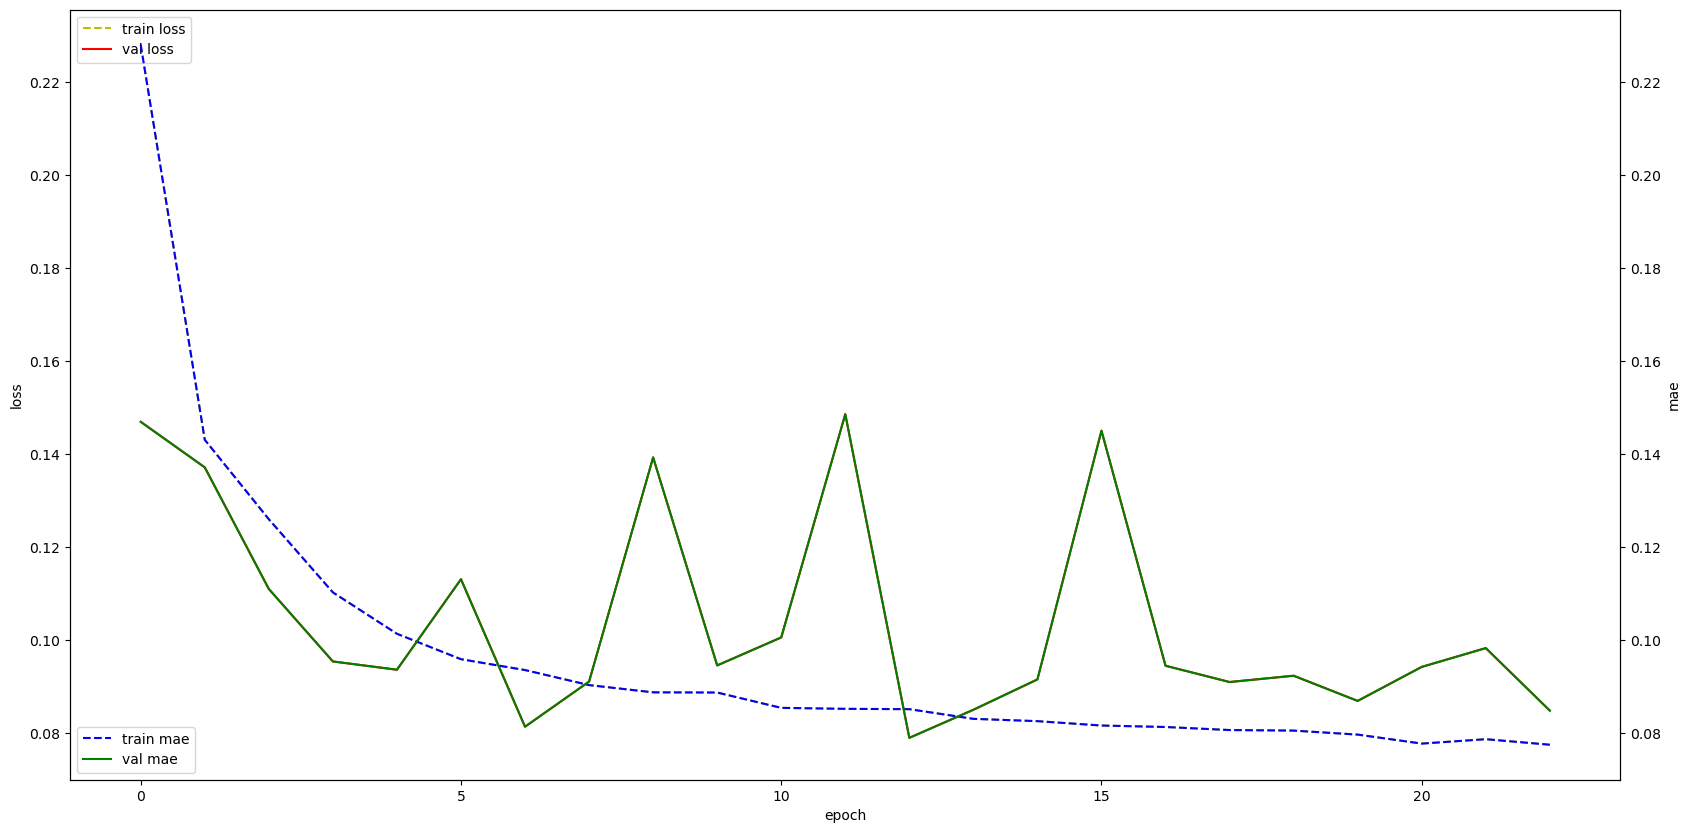

In [7]:
# load weights
model.load_weights(weightcache)
y_pred = model.predict(test_dataset).flatten()
mae_val = mean_absolute_error(y_test, y_pred)

print(f'mae{mae_val*SCALE_Y:.2f}')
open(odir+"/model.json", "wt").write(model.to_json())
os.rename(odir, rootdir+f'/mae{mae_val*SCALE_Y:.2f}_{odir_l}')
tf.keras.backend.clear_session()

plot_hist(hist)

In [6]:
def plot_hist(hist):

    fig, loss_ax = plt.subplots(figsize=(20,10))

    #x-axis는 공유하지만 y-axis는 공유x
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', linestyle='dashed', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

    #acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
    #acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')
    acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
    acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    #acc_ax.set_ylim(0.2,1.0)
    acc_ax.set_ylabel('mae')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

### SAM (Sharpness Aware Minimization with Tensorfow)

In [17]:
# creating a custom train_step to override the train_step method of sub_classing model
def train_step_sam(self, data, rho=0.05):
    """
    Overrides the train_step method of Model
    
    Args:
        data : Data on which model is to be trained
        rho  : Hyperparameter Rho indicating the size of neighborhood
    """
    
    sample_weight = None
    x, y = data

    # Opening Gradient Tape scope to record operations during 1st forward pass
    with tf.GradientTape() as tape:
        y_pred = self(x, training=True)
        # Calculating loss to calculate gradients
        loss = self.compiled_loss(y, y_pred, sample_weight=sample_weight, regularization_losses=self.losses)

    
    trainable_vars = self.trainable_variables
    # Calculating gradients with respect trainable variable
    gradients = tape.gradient(loss, trainable_vars)

    """
    This is the first step which involves calculating the point w_adv with highest loss and virtually moving to that point so that we can get gradient at that point. 
    """
    eps_w_ls = [] # list to store the updates done to trainable variables in first step
    
    #computing the norm of gradients which is required for computing eps_w
    grad_norm = tf.linalg.global_norm(gradients)
    
    # Iterating over trainable_vars
    for i in range(len(trainable_vars)):
        # we will calculate eps_w to find w_adv point having highest loss in rho neighborhood
        eps_w = tf.math.multiply(gradients[i], rho / grad_norm )
        # temporarily moving to w_adv point
        trainable_vars[i].assign_add(eps_w)
        # storing updates done in eps_w_ls list 
        eps_w_ls.append(eps_w)

    # Opening Gradient Tape scope to record operations during 2nd forward pass
    with tf.GradientTape() as tape:
        y_pred = self(x, training=True) 
        # Calculating loss to calculate gradient at w_adv point
        loss = self.compiled_loss(y, y_pred, sample_weight=sample_weight, regularization_losses=self.losses)
        
    trainable_vars = self.trainable_variables
    #computing gradient at w_adv which is our objective in this first step
    gradients = tape.gradient(loss, trainable_vars)

    """
    This is the second step in SAM where we will do actual update at the initial point from the gradient calculated at adversial point w_adv 
    """
    
    for i in range(len(trainable_vars)):
        # Going back to orignal parameters
        trainable_vars[i].assign_sub(eps_w_ls[i])
    
    # Updating parameters with gradients computed at w_adv
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Updating the metrics.
    self.compiled_metrics.update_state(y, y_pred, sample_weight=sample_weight)

    # returns a dictionary mapping metric names (including the loss) to their current value.
    return {m.name: m.result() for m in self.metrics}

In [19]:
# using model subclassing so we can override the train_step
class MyModel(Model):

    # defining the model, for this notebook I will be using ResNet50 model and changing the output layer
    def __init__(self):
        super(MyModel, self).__init__(name='1d-cnn')
        self.base=base_model
     
    def call(self, x):
        x = self.base(x) # calling the resnet50 model
        return x
    
    # overriding the train_step method  with our custom train_step_sam created in earlier cell
    def train_step(self, data):
        return train_step_sam(self, data, rho=0.05) # using rho as 0.05 you can tune this hyperparameter

adult-male-best model: mae7.73+-0.03_max1__batch64,layer1:c64filt15str1,layer2:c128filt7str2,layer3:c16filt15str4,layer4:c128filt9str2,1conv,dropout0.3,dnodes64,dropout0.4
Epoch 1/100
417/418 [============================>.] - ETA: 0s - loss: 0.1402 - mean_absolute_error: 0.1430
Epoch 1: val_loss improved from inf to 0.09999, saving model to randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


418/418 [==============================] - 28s 54ms/step - loss: 0.1402 - mean_absolute_error: 0.1430 - val_loss: 0.1000 - val_mean_absolute_error: 0.1000
Epoch 2/100
417/418 [============================>.] - ETA: 0s - loss: 0.1026 - mean_absolute_error: 0.1050
Epoch 2: val_loss improved from 0.09999 to 0.09229, saving model to randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


418/418 [==============================] - 22s 53ms/step - loss: 0.1026 - mean_absolute_error: 0.1049 - val_loss: 0.0923 - val_mean_absolute_error: 0.0923
Epoch 3/100
417/418 [============================>.] - ETA: 0s - loss: 0.0965 - mean_absolute_error: 0.0989
Epoch 3: val_loss improved from 0.09229 to 0.08597, saving model to randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


418/418 [==============================] - 22s 52ms/step - loss: 0.0965 - mean_absolute_error: 0.0988 - val_loss: 0.0860 - val_mean_absolute_error: 0.0860
Epoch 4/100
417/418 [============================>.] - ETA: 0s - loss: 0.0917 - mean_absolute_error: 0.0942
Epoch 4: val_loss improved from 0.08597 to 0.08473, saving model to randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


418/418 [==============================] - 22s 52ms/step - loss: 0.0918 - mean_absolute_error: 0.0942 - val_loss: 0.0847 - val_mean_absolute_error: 0.0847
Epoch 5/100
417/418 [============================>.] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.0913
Epoch 5: val_loss improved from 0.08473 to 0.08178, saving model to randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


418/418 [==============================] - 22s 53ms/step - loss: 0.0886 - mean_absolute_error: 0.0912 - val_loss: 0.0818 - val_mean_absolute_error: 0.0818
Epoch 6/100
417/418 [============================>.] - ETA: 0s - loss: 0.0873 - mean_absolute_error: 0.0899
Epoch 6: val_loss did not improve from 0.08178
418/418 [==============================] - 19s 45ms/step - loss: 0.0872 - mean_absolute_error: 0.0899 - val_loss: 0.0848 - val_mean_absolute_error: 0.0848
Epoch 7/100
417/418 [============================>.] - ETA: 0s - loss: 0.0857 - mean_absolute_error: 0.0880
Epoch 7: val_loss did not improve from 0.08178
418/418 [==============================] - 19s 45ms/step - loss: 0.0857 - mean_absolute_error: 0.0880 - val_loss: 0.0823 - val_mean_absolute_error: 0.0823
Epoch 8/100
417/418 [============================>.] - ETA: 0s - loss: 0.0848 - mean_absolute_error: 0.0872
Epoch 8: val_loss improved from 0.08178 to 0.08110, saving model to randomSearch/best_model/SRATE500_ECG-bandpass_z-n

INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


418/418 [==============================] - 22s 52ms/step - loss: 0.0848 - mean_absolute_error: 0.0872 - val_loss: 0.0811 - val_mean_absolute_error: 0.0811
Epoch 9/100
417/418 [============================>.] - ETA: 0s - loss: 0.0834 - mean_absolute_error: 0.0861
Epoch 9: val_loss did not improve from 0.08110
418/418 [==============================] - 19s 46ms/step - loss: 0.0834 - mean_absolute_error: 0.0861 - val_loss: 0.0861 - val_mean_absolute_error: 0.0861
Epoch 10/100
417/418 [============================>.] - ETA: 0s - loss: 0.0820 - mean_absolute_error: 0.0844
Epoch 10: val_loss improved from 0.08110 to 0.07854, saving model to randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


418/418 [==============================] - 22s 53ms/step - loss: 0.0820 - mean_absolute_error: 0.0844 - val_loss: 0.0785 - val_mean_absolute_error: 0.0785
Epoch 11/100
417/418 [============================>.] - ETA: 0s - loss: 0.0810 - mean_absolute_error: 0.0835
Epoch 11: val_loss did not improve from 0.07854
418/418 [==============================] - 19s 45ms/step - loss: 0.0810 - mean_absolute_error: 0.0835 - val_loss: 0.0891 - val_mean_absolute_error: 0.0891
Epoch 12/100
418/418 [==============================] - ETA: 0s - loss: 0.0806 - mean_absolute_error: 0.0828
Epoch 12: val_loss did not improve from 0.07854
418/418 [==============================] - 19s 46ms/step - loss: 0.0806 - mean_absolute_error: 0.0828 - val_loss: 0.0795 - val_mean_absolute_error: 0.0795
Epoch 13/100
418/418 [==============================] - ETA: 0s - loss: 0.0800 - mean_absolute_error: 0.0826
Epoch 13: val_loss did not improve from 0.07854
418/418 [==============================] - 20s 47ms/step - loss:

INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


418/418 [==============================] - 23s 54ms/step - loss: 0.0791 - mean_absolute_error: 0.0815 - val_loss: 0.0781 - val_mean_absolute_error: 0.0781
Epoch 15/100
417/418 [============================>.] - ETA: 0s - loss: 0.0780 - mean_absolute_error: 0.0802
Epoch 15: val_loss improved from 0.07808 to 0.07669, saving model to randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


INFO:tensorflow:Assets written to: randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/ckpt/assets


418/418 [==============================] - 23s 54ms/step - loss: 0.0780 - mean_absolute_error: 0.0803 - val_loss: 0.0767 - val_mean_absolute_error: 0.0767
Epoch 16/100
418/418 [==============================] - ETA: 0s - loss: 0.0772 - mean_absolute_error: 0.0794
Epoch 16: val_loss did not improve from 0.07669
418/418 [==============================] - 20s 47ms/step - loss: 0.0772 - mean_absolute_error: 0.0794 - val_loss: 0.0789 - val_mean_absolute_error: 0.0789
Epoch 17/100
418/418 [==============================] - ETA: 0s - loss: 0.0764 - mean_absolute_error: 0.0786
Epoch 17: val_loss did not improve from 0.07669
418/418 [==============================] - 20s 47ms/step - loss: 0.0764 - mean_absolute_error: 0.0786 - val_loss: 0.0817 - val_mean_absolute_error: 0.0817
Epoch 18/100
417/418 [============================>.] - ETA: 0s - loss: 0.0758 - mean_absolute_error: 0.0782
Epoch 18: val_loss did not improve from 0.07669
418/418 [==============================] - 19s 46ms/step - loss:

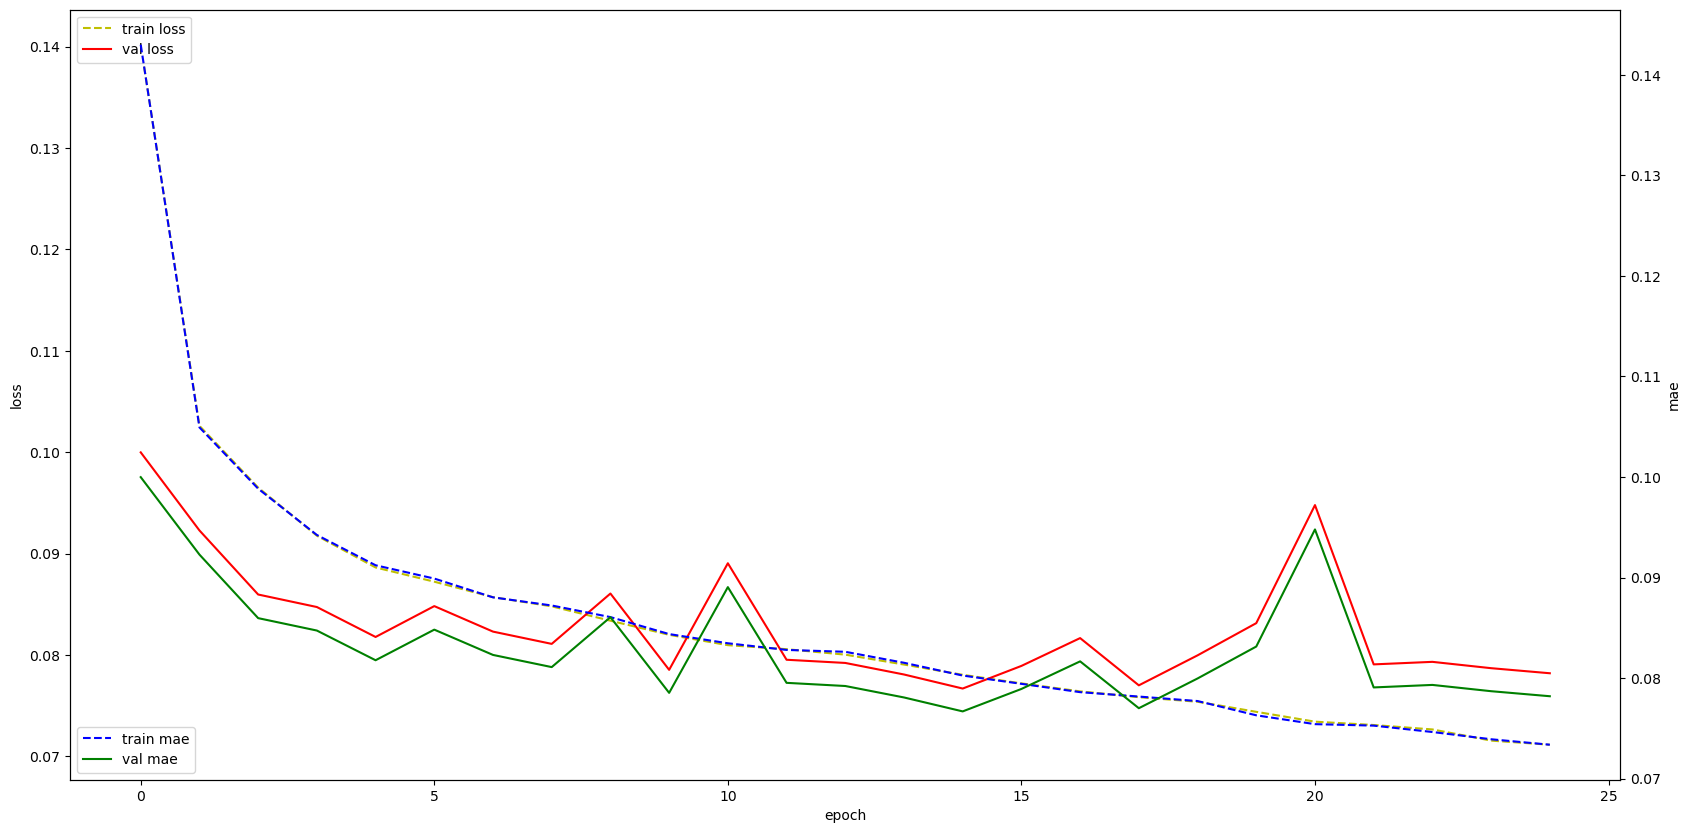

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'randomSearch/best_model/SRATE500_ECG-bandpass_z-norm_adult_male_train/lr0.001_drop0.3_epochs_drop5_decay0.0001_mae/weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [25]:
batch_size = 64
with tf.device(f"/GPU:{GPU}"):
    # load the best model
    base_model, odir_f = best_model(rootdir_load, ADULT, GENDER)
    model = MyModel()
    lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
    #model = SharpnessAwareMinimization(model, num_batch_splits=batch_size)
    model.compile(loss='mean_absolute_error', optimizer=Adam(lr=lr_scheduler, weight_decay=DECAY), metrics=['mean_absolute_error'])

with tf.device("/CPU:0"):
    train_dataset = tf.data.Dataset.from_tensor_slices(({"input_1": x_train, "input_2": feat_train}, y_train)).shuffle(x_train.shape[0]).batch(batch_size)
    #val_dataset = tf.data.Dataset.from_tensor_slices(({"input_1": x_val, "input_2": feat_val}, Y_val)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices(({"input_1": x_test, "input_2": feat_test}, y_test)).batch(batch_size)

    
filepath = f"{odir}/ckpt"
model.save_weights(save_format="tf", filepath=filepath)

weightcache = f"{odir}/weights.h5"
hist = model.fit(train_dataset, validation_data=test_dataset, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                        callbacks=[ModelCheckpoint(monitor='val_loss', filepath=filepath, verbose=1, save_best_only=True),
                                    EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])

plot_hist(hist)

# load weights
model.load_weights(weightcache)
y_pred = model.predict(test_dataset).flatten()
mae_val = mean_absolute_error(y_test, y_pred)

print(f'mae{mae_val*SCALE_Y:.2f}')
open(odir+"/model.json", "wt").write(model.to_json())
os.rename(odir, rootdir+f'/mae{mae_val*SCALE_Y:.2f}_{odir_l}')
tf.keras.backend.clear_session()

In [ ]:
# Instantiating our 1d-cnn Model
base_model, odir_f = best_model(rootdir_load, ADULT, GENDER)
model = MyModel()
model.build((None, 32,32, 3))

# compiling our model with SGD as base optimizer
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Training our Model for 60 epochs
history=model.fit(train_data,
          epochs=60,
          validation_data=test_data)

# Validation of model

In [13]:
def best_model(models_dir, adult, gender, file_name = None):
    #hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{adult}_{gender}_{TRAIN}'
    #models_dir = f"randomSearch/{hyper_path}/CNN_4layers_{nfold}fold_test{ntest}"
    if not file_name:
        model_list = np.array(os.listdir(models_dir))

        mask = [(True if ('mae' in path) else False) for path in model_list]
        model_list = model_list[mask]

        perf_list = [float(path.split('_',1)[0][3:]) for path in model_list]
        best_model_path = model_list[np.argmin(perf_list)]
    else:
        best_model_path = file_name
    
    print(f'{adult}-{gender}-best model: {best_model_path}')
    
    load_path = f'{models_dir}/{best_model_path}'
    with open(load_path+"/model.json", 'r') as f_json:
        loaded_model_json = f_json.read()
        
    loaded_model = model_from_json(loaded_model_json)
    load_weight_path = load_path+'/weights.hdf5'
    loaded_model.load_weights(load_weight_path)
    return loaded_model



SRATE = 500
ECG_FILT = 'bandpass'
TRAIN = 'train'
ADULT = 'adult'
NORM = 'z-norm'
GENDER = 'female'

hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
input_path = f'dataset/{hyper_path}/'

nfold = 4 
ntest = 500
rootdir = f"randomSearch/{hyper_path}/CNN_4layers_{nfold}fold_test{ntest}"

# loading best model in rootdir
ADULT = 'adult'
GENDER = 'male'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
rootdir = f'randomSearch/best_model/{hyper_path}'
model1 = best_model(rootdir, ADULT, GENDER)

hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
rootdir = f'randomSearch/best_model/{hyper_path}'
model2 = best_model(rootdir, ADULT, GENDER, file_name = 'mae7.90_lr0.001_drop0.3_epochs_drop5_decay0.0001_mae')

adult-male-best model: mae7.52_lr0.001_drop0.3_epochs_drop5_decay0.0001_mae
adult-male-best model: mae7.90_lr0.001_drop0.3_epochs_drop5_decay0.0001_mae


In [16]:
y_pred1 = model1.predict([x_test, feat_test]).flatten()
mae_val = mean_absolute_error(y_test, y_pred1)
print(mae_val)

y_pred2 = model2.predict([x_test]).flatten()
mae_val = mean_absolute_error(y_test, y_pred2)
print(mae_val)

106/106 [==============================] - 1s 5ms/step
0.075234696
106/106 [==============================] - 2s 12ms/step
0.07897104


In [19]:
df = pd.DataFrame({'test':y_test, 'pred':y_pred1})
df['mae'] = df.apply(lambda x: abs(x['pred']-x['test']), axis=1)

for i in range(1,11):
    df[i*10] = df.apply(lambda x: x['mae'] if ((x['test']>i*0.1) & (x['test']<=(i+1)*0.1)) else np.nan, axis=1)

df.describe()

,test,pred,mae,10,20,30,40,50,60,70,80,90,100
count,3387.000000,3387.000000,3387.000000,14.000000,181.000000,202.000000,342.000000,475.000000,1029.000000,759.000000,370.000000,14.000000,1.000000
mean,0.618471,0.617424,0.075235,0.113708,0.115386,0.099998,0.100173,0.080510,0.050915,0.061137,0.102987,0.182658,0.185522
std,0.161143,0.130446,0.061876,0.095484,0.098796,0.086157,0.069153,0.052025,0.043065,0.046837,0.057046,0.049549,NaN
min,0.190000,0.140956,0.000010,0.014329,0.001078,0.000652,0.000337,0.000024,0.000021,0.000010,0.001642,0.098325,0.185522
25%,0.530000,0.568441,0.028746,0.022126,0.042259,0.036766,0.042134,0.039997,0.018140,0.022860,0.059383,0.159040,0.185522
50%,0.650000,0.651187,0.061605,0.098657,0.090398,0.077698,0.088089,0.075327,0.040824,0.052485,0.099882,0.175289,0.185522
75%,0.730000,0.706085,0.104967,0.182838,0.161954,0.144694,0.147061,0.109759,0.072374,0.088521,0.139318,0.213036,0.185522
max,1.010000,0.856229,0.499697,0.274908,0.499697,0.493560,0.305530,0.315509,0.311507,0.334789,0.377677,0.266641,0.185522


In [20]:
df2 = pd.DataFrame({'test':y_test, 'pred':y_pred2})
df2['mae'] = df2.apply(lambda x: abs(x['pred']-x['test']), axis=1)

for i in range(1,11):
    df2[i*10] = df2.apply(lambda x: x['mae'] if ((x['test']>i*0.1) & (x['test']<=(i+1)*0.1)) else np.nan, axis=1)

df2.describe()

,test,pred,mae,10,20,30,40,50,60,70,80,90,100
count,3387.000000,3387.000000,3387.000000,14.000000,181.000000,202.000000,342.000000,475.000000,1029.000000,759.000000,370.000000,14.000000,1.000000
mean,0.618471,0.630400,0.078971,0.168629,0.156007,0.118555,0.102793,0.080322,0.057370,0.056135,0.095213,0.180171,0.229006
std,0.161143,0.119888,0.064748,0.057670,0.099392,0.092783,0.072385,0.057834,0.040758,0.047655,0.051515,0.044119,NaN
min,0.190000,0.306930,0.000006,0.118386,0.020453,0.001603,0.000637,0.000812,0.000010,0.000006,0.012363,0.140458,0.229006
25%,0.530000,0.569260,0.030409,0.127958,0.091650,0.037709,0.046851,0.032719,0.024648,0.020256,0.058949,0.148939,0.229006
50%,0.650000,0.657312,0.065636,0.147452,0.124666,0.102434,0.088186,0.073544,0.050673,0.043094,0.087534,0.162783,0.229006
75%,0.730000,0.724105,0.110332,0.190982,0.198992,0.176450,0.145808,0.116193,0.083124,0.078670,0.127395,0.187404,0.229006
max,1.010000,0.792045,0.558407,0.324597,0.558407,0.444042,0.345914,0.263934,0.256358,0.252054,0.311937,0.276563,0.229006


In [56]:
df.describe()

,test,pred,mae,10,20,30,40,50,60,70,80,90,100
count,3575.000000,3575.000000,3575.000000,10.000000,201.000000,307.000000,475.000000,488.000000,1017.000000,708.000000,353.000000,15.000000,1.000000
mean,0.599485,0.607395,0.073117,0.109605,0.119526,0.093054,0.079730,0.074012,0.052850,0.058026,0.101256,0.190286,0.288422
std,0.166702,0.134671,0.060290,0.046060,0.088729,0.081551,0.060262,0.050631,0.042292,0.047274,0.059744,0.052589,NaN
min,0.190000,0.214290,0.000084,0.035075,0.000737,0.000140,0.000133,0.000698,0.000169,0.000084,0.001584,0.126524,0.288422
25%,0.485000,0.518002,0.028747,0.083407,0.053914,0.033028,0.030195,0.035536,0.019674,0.023223,0.057654,0.143191,0.288422
50%,0.630000,0.645825,0.059447,0.110039,0.110481,0.069111,0.068092,0.066654,0.043125,0.049558,0.094609,0.170482,0.288422
75%,0.730000,0.708460,0.102116,0.133731,0.149544,0.124773,0.115438,0.103201,0.075931,0.079386,0.134954,0.230811,0.288422
max,1.010000,0.872304,0.498771,0.187503,0.498771,0.418843,0.324631,0.272368,0.269658,0.405059,0.366238,0.286834,0.288422
